#Donut: OCR-Free Document Understanding with Donut

In this Jupyter notebook I implemented donut to ectract information from medical bill in json formats In order to complete my task a, I implemented a Jupyter notebook featuring a donut for extracting information from medical bills in JSON format. The task revolves around visual document understanding (VDU) in the realm of deep learning and data science, addressing the abundance of unstructured data in PDFs and document scans. Noteworthy models such as LayoutLM, LayoutLMv2, and LayoutLMv3, leveraging transformers, have proven highly effective in this context.

## Set-up environment

First, we install 🤗 Transformers, Datasets and SentencePiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load image

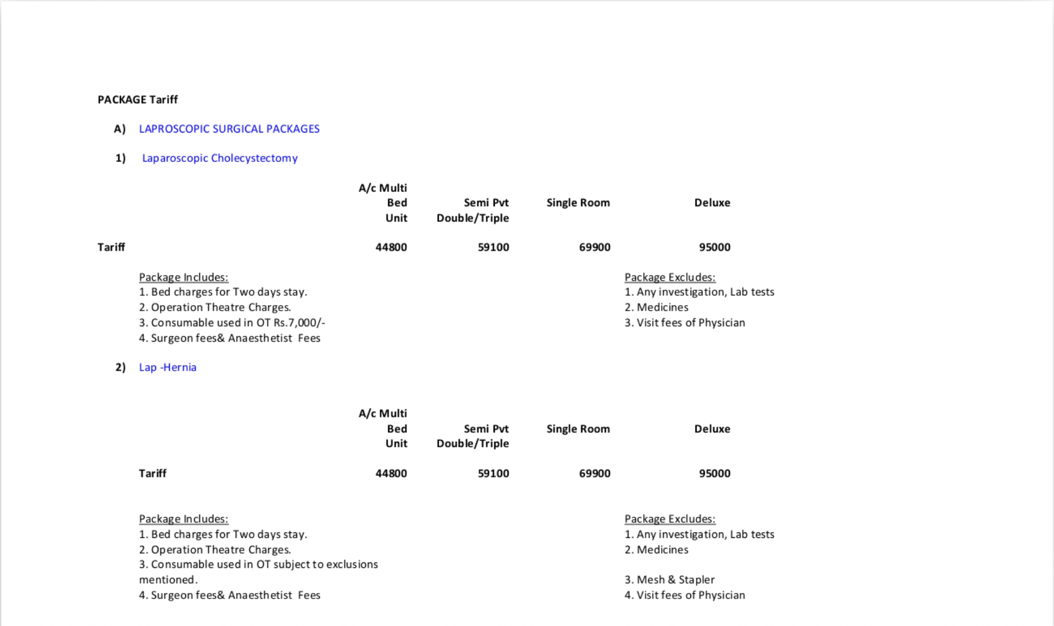

In [16]:
from PIL import Image
image = Image.open('/content/sample_data/Excercise 2 data2_page-0003.jpg').convert("RGB")
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

## Load model and processor

In [17]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [18]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [19]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

In [20]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_menu><s_nm> PACAGE Taniff</s_nm><s_unitprice> LAPROSOPIC SURGICAL PACKAGES</s_nm><s_unitprice> Laparoscope Cholepasteomy</s_nm><s_unitprice> A/EMulti</s_nm><s_unitprice> Smile Box Smile Box Deluxe Bed Unit Double/triple</s_nm><s_unitprice> 6900</s_unitprice><s_cnt> 4,820</s_unitprice><s_cnt> 59,00</s_cnt><s_price> 9,000</s_price><sep/><s_nm> Package Industs: Pockets: Lami cheeses Two 여자 snacky</s_nm><s_unitprice> Amymesters, La.Deteat. These Charges.</s_nm><s_unitprice> 2,Modenes</s_nm><s_unitprice> 3. Consumpable used in TR. 7.000/</s_unitprice><s_cnt> 3. Yohi Fes of Frydman</s_nm><s_unitprice> 2.Outside Flying Lamiशियन</s_unitprice><s_cnt> 2.</s_cnt><s_price> 3,000</s_price><sep/><s_nm> Logo Horini Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat Salamat 59,100</s_unitprice><s_cnt> 6,9000</s_cnt><s_price> 9,000</s_price><sep/><s_nm> 1.BeachangeExcludes:除了除了除了工作人員 2.Modiches</s_nm><s_unitprice> 2.Modiches</s_nm><s_unitprice> 3.

## Convert to JSON

We can convert the generated sequence to JSON if required:

In [21]:
processor.token2json(sequence)

[{'nm': 'PACAGE Taniff', 'price': '9,000'},
 {'nm': 'Package Industs: Pockets: Lami cheeses Two 여자 snacky',
  'cnt': {'unitprice': '2.Outside Flying Lamiशियन'},
  'price': '3,000'},
 {'nm': {'cnt': '6,9000', 'price': '9,000'},
  'total': {'total_price': '4.Visifies of Phygian'}}]